# Tutorial: Resolution of an inverse problem

### Introduction to the inverse problem

This tutorial shows how to solve an inverse Poisson problem with Physics-Informed Neural Networks. The problem definition is that of a Poisson problem with homogeneous boundary conditions and it reads:
\begin{equation}
\begin{cases}
\Delta u = e^{-2(x-\mu_1)^2-2(y-\mu_2)^2} \text{ in } \Omega\, ,\\
u = 0 \text{ on }\partial \Omega,\\
u(\mu_1, \mu_2) = \text{ data}
\end{cases}
\end{equation}
where $\Omega$ is a square domain $[-2, 2] \times [-2, 2]$, and $\partial \Omega=\Gamma_1 \cup \Gamma_2 \cup \Gamma_3 \cup \Gamma_4$ is the union of the boundaries of the domain.

This kind of problem, namely the "inverse problem", has two main goals:
- find the solution $u$ that satisfies the Poisson equation;
- find the unknown parameters ($\mu_1$, $\mu_2$) that better fit some given data (third equation in the system above).

In order to achieve both goals we will need to define an `InverseProblem` in PINA.

Let's start with useful imports.

In [3]:
import matplotlib.pyplot as plt
import torch
from pytorch_lightning.callbacks import Callback
import sys

sys.path.append('C:/Users/Andrea/Desktop/Poli/Tesi magistrale/reporitory_SISSA_PoliTO')

from pina.problem import SpatialProblem, InverseProblem
from pina.operators import laplacian
from pina.model import FeedForward
from pina.equation import Equation, FixedValue
from pina import Condition, Trainer
from pina.solvers import PINN
from pina.geometry import CartesianDomain

Then, we import the pre-saved data, for ($\mu_1$, $\mu_2$)=($0.5$, $0.5$). These two values are the optimal parameters that we want to find through the neural network training. In particular, we import the `input_points`(the spatial coordinates), and the `output_points` (the corresponding $u$ values evaluated at the `input_points`).

In [4]:
data_output = torch.load('data/pinn_solution_0.5_0.5').detach()
data_input = torch.load('data/pts_0.5_0.5')

Moreover, let's plot also the data points and the reference solution: this is the expected output of the neural network.

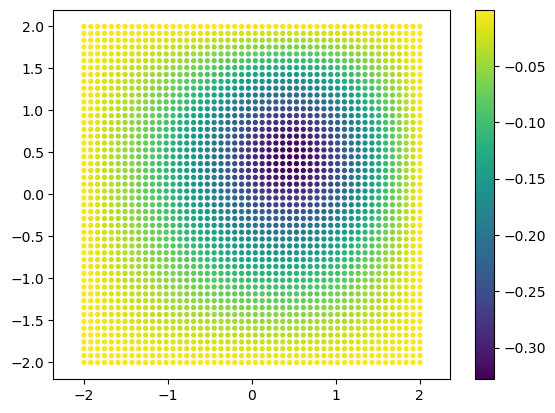

In [5]:
points = data_input.extract(['x', 'y']).detach().numpy()
truth = data_output.detach().numpy()

plt.scatter(points[:, 0], points[:, 1], c=truth, s=8)
plt.axis('equal')
plt.colorbar()
plt.show()

### Inverse problem definition in PINA

Then, we initialize the Poisson problem, that is inherited from the `SpatialProblem` and from the `InverseProblem` classes. We here have to define all the variables, and the domain where our unknown parameters ($\mu_1$, $\mu_2$) belong. Notice that the Laplace equation takes as inputs also the unknown variables, that will be treated as parameters that the neural network optimizes during the training process.

In [6]:
### Define ranges of variables
x_min = -2
x_max = 2
y_min = -2
y_max = 2

class Poisson(SpatialProblem, InverseProblem):
    '''
    Problem definition for the Poisson equation.
    '''
    output_variables = ['u']
    spatial_domain = CartesianDomain({'x': [x_min, x_max], 'y': [y_min, y_max]})
    # define the ranges for the parameters
    unknown_parameter_domain = CartesianDomain({'mu1': [-1, 1], 'mu2': [-1, 1]})

    def laplace_equation(input_, output_, params_):
        '''
        Laplace equation with a force term.
        '''
        force_term = torch.exp(
                - 2*(input_.extract(['x']) - params_['mu1'])**2
                - 2*(input_.extract(['y']) - params_['mu2'])**2)
        delta_u = laplacian(output_, input_, components=['u'], d=['x', 'y'])

        return delta_u - force_term

    # define the conditions for the loss (boundary conditions, equation, data)
    conditions = {
        'gamma1': Condition(location=CartesianDomain({'x': [x_min, x_max],
            'y':  y_max}),
            equation=FixedValue(0.0, components=['u'])),
        'gamma2': Condition(location=CartesianDomain({'x': [x_min, x_max], 'y': y_min
            }),
            equation=FixedValue(0.0, components=['u'])),
        'gamma3': Condition(location=CartesianDomain({'x':  x_max, 'y': [y_min, y_max]
            }),
            equation=FixedValue(0.0, components=['u'])),
        'gamma4': Condition(location=CartesianDomain({'x': x_min, 'y': [y_min, y_max]
            }),
            equation=FixedValue(0.0, components=['u'])),
        'D': Condition(location=CartesianDomain({'x': [x_min, x_max], 'y': [y_min, y_max]
            }),
        equation=Equation(laplace_equation)),
        'data': Condition(input_points=data_input.extract(['x', 'y']), output_points=data_output) #QUESTA è LA CONDIZIONE IMPORTANTE CHE FA IN MODO CHE SI SODDISFINO I DATI
    }

problem = Poisson()

Then, we define the neural network model we want to use. Here we used a model which imposes hard constrains on the boundary conditions, as also done in the Wave tutorial!

In [7]:
model = FeedForward(
    layers=[20, 20, 20],
    func=torch.nn.Softplus,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
    )

After that, we discretize the spatial domain.

In [8]:
problem.discretise_domain(20, 'grid', locations=['D'], variables=['x', 'y'])
problem.discretise_domain(1000, 'random', locations=['gamma1', 'gamma2', 'gamma3', 'gamma4'], variables=['x', 'y'])

Here, we define a simple callback for the trainer. We use this callback to save the parameters predicted by the neural network during the training. The parameters are saved every 100 epochs as `torch` tensors in a specified directory (`tmp_dir` in our case).
The goal is to read the saved parameters after training and plot their trend across the epochs.

In [9]:
# temporary directory for saving logs of training
tmp_dir = "tmp_poisson_inverse"

class SaveParameters(Callback):
    '''
    Callback to save the parameters of the model every 100 epochs.
    '''
    def on_train_epoch_end(self, trainer, __):
        if trainer.current_epoch % 100 == 99:
            torch.save(trainer.solver.problem.unknown_parameters, '{}/parameters_epoch{}'.format(tmp_dir, trainer.current_epoch))

Then, we define the `PINN` object and train the solver using the `Trainer`.

In [10]:
### train the problem with PINN
max_epochs = 5000
pinn = PINN(problem, model, optimizer_kwargs={'lr':0.005})
# define the trainer for the solver
trainer = Trainer(solver=pinn, accelerator='cpu', max_epochs=max_epochs,
        default_root_dir=tmp_dir, callbacks=[SaveParameters()])
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Andrea\anaconda3\envs\PINA2\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Missing logger folder: tmp_poisson_inverse\lightning_logs

  | Name        | Type    | Params
----------------------------------------
0 | _loss       | MSELoss | 0     
1 | _neural_net | Network | 921   
----------------------------------------
921       Trainable params
0     

Epoch 4999: 100%|██████████| 2/2 [00:00<00:00,  4.70it/s, v_num=0, gamma1_loss=8.73e-7, gamma2_loss=3.96e-7, gamma3_loss=7.07e-7, gamma4_loss=5.04e-7, D_loss=9.86e-6, mean_loss=3.57e-6, data_loss=5.5e-6]        

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s, v_num=0, gamma1_loss=8.73e-7, gamma2_loss=3.96e-7, gamma3_loss=7.07e-7, gamma4_loss=5.04e-7, D_loss=9.86e-6, mean_loss=3.57e-6, data_loss=5.5e-6]


One can now see how the parameters vary during the training by reading the saved solution and plotting them. The plot shows that the parameters stabilize to their true value before reaching the epoch $1000$!

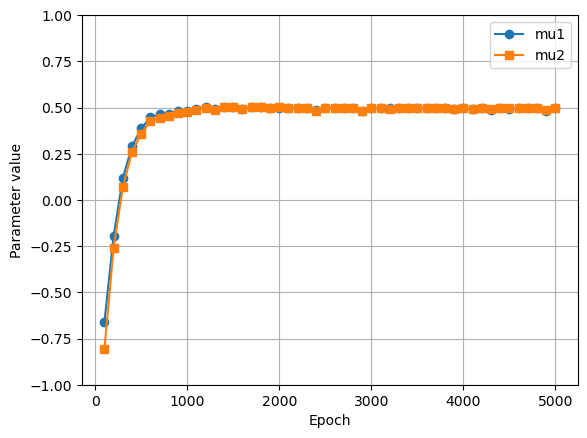

In [11]:
epochs_saved = range(99, max_epochs, 100)
parameters = torch.empty((int(max_epochs/100), 2))
for i, epoch in enumerate(epochs_saved):
    params_torch = torch.load('{}/parameters_epoch{}'.format(tmp_dir, epoch))
    for e, var in enumerate(pinn.problem.unknown_variables):
        parameters[i, e] = params_torch[var].data

# Plot parameters
plt.close()
plt.plot(epochs_saved, parameters[:, 0], label='mu1', marker='o')
plt.plot(epochs_saved, parameters[:, 1], label='mu2', marker='s')
plt.ylim(-1, 1)
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Parameter value')
plt.show()

Dal vettore di sotto si vede evidentemente che i due parametri sono mu1 = mu2 = 0.5 circa

In [12]:
parameters

tensor([[-0.6587, -0.8084],
        [-0.1938, -0.2577],
        [ 0.1185,  0.0685],
        [ 0.2912,  0.2603],
        [ 0.3869,  0.3594],
        [ 0.4487,  0.4277],
        [ 0.4626,  0.4457],
        [ 0.4648,  0.4514],
        [ 0.4793,  0.4695],
        [ 0.4794,  0.4748],
        [ 0.4936,  0.4884],
        [ 0.5009,  0.4982],
        [ 0.4900,  0.4882],
        [ 0.5018,  0.5006],
        [ 0.5038,  0.5040],
        [ 0.4946,  0.4938],
        [ 0.5015,  0.5019],
        [ 0.5012,  0.5023],
        [ 0.4964,  0.4958],
        [ 0.4999,  0.5002],
        [ 0.4989,  0.4992],
        [ 0.4976,  0.4966],
        [ 0.4988,  0.4980],
        [ 0.4858,  0.4831],
        [ 0.4987,  0.4973],
        [ 0.4981,  0.4970],
        [ 0.4971,  0.4957],
        [ 0.4981,  0.4971],
        [ 0.4826,  0.4814],
        [ 0.4979,  0.4972],
        [ 0.4974,  0.4973],
        [ 0.4955,  0.4943],
        [ 0.4971,  0.4976],
        [ 0.4965,  0.4975],
        [ 0.4967,  0.4976],
        [ 0.4964,  0